In [1]:
# 1. Text Processing & NLP Libraries
import re
import spacy
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser

# 2. Data Manipulation & Analysis
import pandas as pd
import numpy as np

# 3. Visualization Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 4. Machine Learning & Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF


# Load Data Loading

In [2]:
df = pd.read_csv('economy_class_df.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Review,Seat Type
0,0,0,No staff at the transfer desk to issue board...,Economy Class
1,1,1,It would appear that Ryanair have produced a...,Economy Class
2,2,2,I was on a 3-month trip with most of my favo...,Economy Class
3,3,3,Excellent and professional. We had our child...,Economy Class
4,4,4,One of the worst experiences ever. Hardly an...,Economy Class


# Data Pre-processing

In [3]:
# Get English stopwords
stop_words = set(stopwords.words('english'))  

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')  

# Preprocessing function
def preprocess(doc):
    
    # Remove email addresses
    doc = re.sub(r'\S*@\S*\s?', '', doc)
    
    # Process the document using SpaCy
    spacy_doc = nlp(doc)
    
    # Lemmatize tokens, keep only alphabetic tokens of length >= 3
    lemmatized_tokens = [token.lemma_ for token in spacy_doc if token.is_alpha and len(token) >= 3]
    
    # Convert tokens to lowercase and remove stopwords
    cleaned_tokens = [token.lower() for token in lemmatized_tokens if token.lower() not in stop_words]
    
    return cleaned_tokens

In [4]:
# Apply preprocessing function
df['Processed_comments'] = df['Review'].apply(preprocess)
df.head()

,Unnamed: 0.1,Unnamed: 0,Review,Seat Type,Processed_comments
0,0,0,No staff at the transfer desk to issue board...,Economy Class,"[staff, transfer, desk, issue, boarding, pass,..."
1,1,1,It would appear that Ryanair have produced a...,Economy Class,"[would, appear, ryanair, produce, race, bottom..."
2,2,2,I was on a 3-month trip with most of my favo...,Economy Class,"[month, trip, favorite, clothe, air, transat, ..."
3,3,3,Excellent and professional. We had our child...,Economy Class,"[excellent, professional, child, fly, illinois..."
4,4,4,One of the worst experiences ever. Hardly an...,Economy Class,"[one, bad, experience, ever, hardly, anything,..."


# N-Grams

In [5]:
# Define the LBMD (Logarithmic Bigram Mutual Dependency) function
def lbmd(worda_count, wordb_count, bigram_count, len_vocab, min_count, corpus_word_count, delta=1):
    # Calculate probabilities
    # Joint probability of A and B co-occurrce (bigram)
    p_xy = bigram_count / corpus_word_count  
    
    # Probability of word A occurring
    p_x = worda_count / corpus_word_count  
    
    # Probability of word B occurring
    p_y = wordb_count / corpus_word_count  
    
    # Return the LBMD score
    return np.log(p_xy + delta) - np.log(p_x * p_y + delta)

#  N-grams (bigrams and trigrams) functions using PMI and LBMD
def make_n_grams(texts, min_count=10, threshold=0.3):
    
    # Detect bigrams using normalized PMI 
    bigram = Phrases(texts, min_count=min_count, threshold=threshold, scoring='npmi')
    bigram_mod = Phraser(bigram) 
    
    # Detect trigrams using LBMD 
    trigram = Phrases(bigram[texts], threshold=50, scoring=lbmd) 
    trigram_mod = Phraser(trigram) 
    
    # Apply the bigram and trigram models to the tokenized texts
    bigrams_text = [bigram_mod[doc] for doc in texts] 
    trigrams_text = [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    
    return trigrams_text  # Return texts containing bigrams and trigrams

# Apply the N-gram fucntion to processed comments
tokens_reviews = make_n_grams(df['Processed_comments'])

# Rejoin the tokenized N-grams into full sentences for Bag of Words
tokens_reviews_joined = [' '.join(doc) for doc in tokens_reviews]

# Feature Etraction

In [6]:
# Initialize CountVectorizer for text vectorization
vectorizer = CountVectorizer(
    analyzer='word',                # Analyze words 
    ngram_range=(1, 3),             # Extract 1-grams, 2-grams, and 3-grams
    min_df=10)                      # Ignore terms that appear in fewer than 10 documents

# Fit the vectorizer to the data and transform the tokenized and joined reviews into a document-term matrix
data_vectorized = vectorizer.fit_transform(tokens_reviews_joined)

In [7]:
# Create a dictionary based on the tokenized reviews
id2word = corpora.Dictionary(tokens_reviews)

# Topic Modeling

In [8]:
def compute_coherence_values(data_vectorized, texts, dictionary, vectorizer, start=2, limit=15, step=1, random_state=42):
    """
    Compute coherence values of three models with different topic numbers.

    Parameters:
    - model_type: NMF
    - data_vectorized: Document-term matrix
    - texts: Tokenized texts after pre-processing
    - dictionary: Gensim dictionary based on the tokenized texts
    - vectorizer: CountVectorizer
    - start: Minimum topic number
    - limit: Maximum topic number 
    - step: Step size for different topic numbers
    - random_state: Random seed for reproducibility

    Returns:
    - coherence_values: A list of coherence values for different numbers of topics
    """
    
    # Initialize an empty list for coherence values
    coherence_values = []
    
    # The range of topic numbers
    topic_numbers = range(start, limit, step)

    for num_topics in topic_numbers:
        # Initialize the respective topic model
        model = NMF(n_components=num_topics, random_state=random_state)

        # Fit the model to the vectorized data and transform the data
        model_output = model.fit_transform(data_vectorized)

        # Extract the top words from each topic
        topics = []
        for topic in model.components_:
            # Get the top 10 words for each topic
            top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            topics.append(top_words)

        # Compute coherence value using Gensim's CoherenceModel
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append(coherence) 

    # Return the topic numbers and their corresponding coherence values
    return topic_numbers, coherence_values

In [9]:
# Apply compute_coherence_values function
nmf_topic_numbers, nmf_coherences = compute_coherence_values(data_vectorized, tokens_reviews, id2word, vectorizer, start=6, limit=16)

/Users/lizihe/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


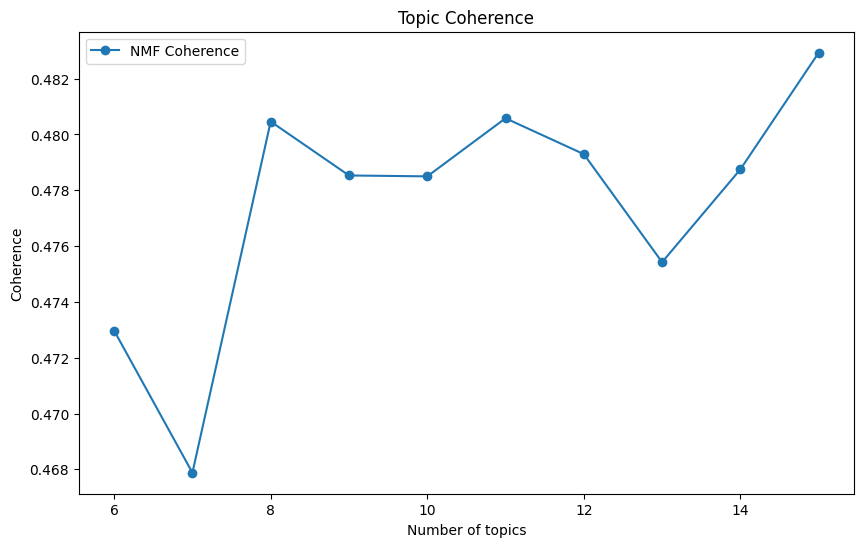

In [10]:
# Visualize the coherence scores of three models
plt.figure(figsize=(10, 6))

plt.plot(nmf_topic_numbers, nmf_coherences, marker='o', label='NMF Coherence')

plt.title('Topic Coherence')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.legend()

plt.show()

In [11]:
print(f"nmf coherences: {nmf_coherences} \n")

nmf coherences: [0.4729705926636667, 0.46787838885197436, 0.48046005559108707, 0.4785286330955756, 0.4784964393009893, 0.48057830395080736, 0.47929231934906863, 0.4754218170992553, 0.47874820849692334, 0.4829261966471734] 



## The Optimal NMF Model Visualization

In [12]:
def extract_topics(model, feature_names, topic_values, num_top_words=10):
    """
    Extract topic information containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"

    Parameters:
    - model: NMF
    - feature_names: List of feature names from CountVectorizer
    - topic_values: Document-term matrix
    - num_top_words: Top 10 keywords

    Returns:
    - topic_df: Data Frame containing "Topic", "Topic Title", "Key Words", and "Topic Share (%)"
    """
    
    # List of top words for each topic
    topic_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Index of the top words for the topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        
        # Map the indexs to the features
        top_features = [feature_names[i] for i in top_features_ind]
        topic_words.append(", ".join(top_features))
    
    # Calculate topic proportions
    topic_proportions = np.mean(np.abs(topic_values), axis=0)
    
    # Normalize topic proportions 
    topic_proportions /= topic_proportions.sum()
    
    # Convert proportions to percentages
    topic_proportions *= 100
    
    # Summarize topic information
    topic_data = {
        "Topic ID": [i+1 for i in range(len(model.components_))],  # Topic number
        "Topic Title": [f"Topic {i+1}" for i in range(len(model.components_))],  # Placeholder for topic label
        "Key Words": topic_words,  # List of top words for each topic
        "Topic Share (%)": [f"{prop:.2f}%" for prop in topic_proportions]  # Topic proportions as percentages
    }

    topic_df = pd.DataFrame(topic_data)
    
    return topic_df  


In [13]:
# Initialize the optimal NMF model with 10 components
optimal_nmf_model = NMF(n_components=15, random_state=42)
# Document-topic matrix (W)  
W = optimal_nmf_model.fit_transform(data_vectorized)
# Topic-word matrix (H)
H = optimal_nmf_model.components_

# Apply extract_topics function to the NMF
topics_df_nmf = extract_topics(optimal_nmf_model, vectorizer.get_feature_names_out(), W)

# Save to a CSV file
topics_df_nmf.to_csv(f'economy_class_topics.csv', index=True)
topics_df_nmf

,Topic ID,Topic Title,Key Words,Topic Share (%)
0,1,Topic 1,"flight, book, cancel, next, early, book flight...",13.16%
1,2,Topic 2,"tell, would, say, ask, could, call, go, give, ...",5.74%
2,3,Topic 3,"service, good, food, meal, crew, cabin, cabin_...",9.35%
3,4,Topic 4,"seat, pay, row, economy, sit, change, hour, mo...",6.87%
4,5,Topic 5,"airline, even, travel, bad, use, pay, experien...",7.16%
5,6,Topic 6,"get, back, go, try, could, flight get, people,...",6.28%
6,7,Topic 7,"hour, delay, airport, wait, hotel, flight dela...",5.47%
7,8,Topic 8,"time, flight time, arrive, take, change, long,...",7.16%
8,9,Topic 9,"check, luggage, line, pay, boarding, baggage, ...",5.04%
9,10,Topic 10,"fly, would, experience, year, route, also, wel...",7.04%
